## Import Statements

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Read and Clean the Data

In [2]:
df = pd.read_csv("outputs/merged_def.csv")  # or use your DataFrame directly

# Handle missing values if any
df = df.dropna(subset=['drtgPlayer'])  # Drop rows with no target
df.fillna(0, inplace=True)  # Replace remaining NaNs with 0
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 0 to 974
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  917 non-null    int64  
 1   Player      917 non-null    object 
 2   Team        917 non-null    object 
 3   Conf        917 non-null    object 
 4   height      917 non-null    float64
 5   mpg         917 non-null    float64
 6   gp          917 non-null    float64
 7   drtgPlayer  917 non-null    float64
 8   ortgPlayer  917 non-null    float64
 9   ws          917 non-null    float64
 10  ows         917 non-null    float64
 11  dws         917 non-null    float64
 12  rapm        917 non-null    float64
 13  orapm       917 non-null    float64
 14  drapm       917 non-null    float64
 15  stl         917 non-null    float64
 16  blk         917 non-null    float64
 17  stlPg       917 non-null    float64
 18  blkPg       917 non-null    float64
 19  Poss        917 non-null    float6

## Feature Selection

In [3]:
features = [
    'height', 'mpg', 'gp', 'ortgPlayer', 'ws', 'ows', 'dws',
    'rapm', 'orapm', 'drapm', 'stl', 'blk', 'stlPg', 'blkPg', 'Poss',
    'PPP', 'PPS'
]
target = 'drtgPlayer'


## Train/Test Split

In [4]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Random Forest Model Training

In [5]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Model Evaluation 

In [6]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")


RMSE: 2.96
R^2 Score: 0.85


### cross validation

In [7]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Mean CV R^2: {cv_scores.mean():.2f}")


Mean CV R^2: 0.85


## Feature Importance

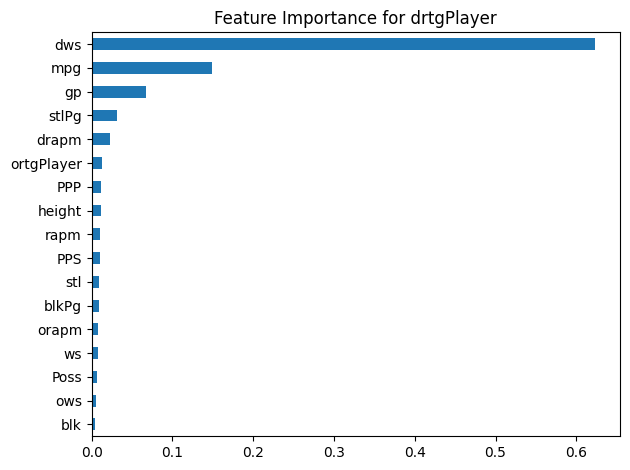

dws: 0.62
mpg: 0.15
gp: 0.07
stlPg: 0.03
drapm: 0.02
ortgPlayer: 0.01
PPP: 0.01
height: 0.01
rapm: 0.01
PPS: 0.01
stl: 0.01
blkPg: 0.01
orapm: 0.01
ws: 0.01
Poss: 0.01
ows: 0.01
blk: 0.00


In [8]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

feat_imp.plot(kind='barh', title='Feature Importance for drtgPlayer')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
# Print feature importances with feature names
sorted_indices = importances.argsort()[::-1]
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]:.2f}")


In [11]:
# Covariance matrix between features
cov_matrix = df[features].cov()
print("Covariance Matrix:")
#print(cov_matrix)

# Correlation matrix between features and target
corr_matrix = df[features + [target]].corr()
print("\nCorrelation Matrix (features with target):")
print(corr_matrix[target].sort_values(ascending=True))

Covariance Matrix:

Correlation Matrix (features with target):
dws          -0.603612
drapm        -0.457627
rapm         -0.415920
ws           -0.395962
blkPg        -0.326123
blk          -0.322301
stlPg        -0.304522
stl          -0.274654
orapm        -0.242988
ortgPlayer   -0.241974
ows          -0.234105
height       -0.206683
gp           -0.174995
mpg          -0.098022
Poss         -0.093966
PPS          -0.016234
PPP          -0.006353
drtgPlayer    1.000000
Name: drtgPlayer, dtype: float64


In [12]:
import numpy as np
import pandas as pd

# Assuming 'cov_matrix' is your covariance matrix
cov_matrix = pd.DataFrame(cov_matrix)  # Your matrix here

# 1. Convert to correlation
std_devs = np.sqrt(np.diag(cov_matrix))
correlation_matrix = cov_matrix / np.outer(std_devs, std_devs)

# 2. Flag high correlations
significant_correlations = correlation_matrix.abs() > 0.3
significant_pairs = correlation_matrix[significant_correlations].stack().dropna()

# 3. Multicollinearity check
high_vif_vars = []
for col in cov_matrix.columns:
    vif = 1 / (1 - correlation_matrix[col][col]**2)  # Variance Inflation Factor
    if vif > 5:  # Common threshold
        high_vif_vars.append(col)
print(high_vif_vars)

['height', 'mpg', 'ortgPlayer', 'orapm', 'stl', 'stlPg', 'blkPg', 'Poss', 'PPP', 'PPS']


/var/folders/qh/zhr4gq8s5px2ff46zwfdk90hy3y30j/T/ipykernel_57046/994867576.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1 / (1 - correlation_matrix[col][col]**2)  # Variance Inflation Factor


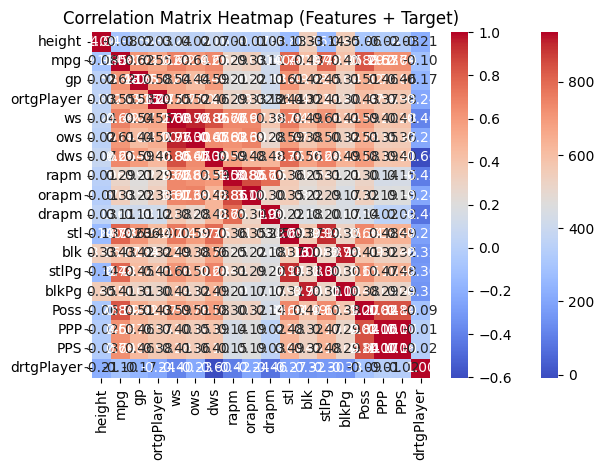

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Covariance matrix heatmap
#plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Covariance Matrix Heatmap")
plt.tight_layout()
#plt.show()

# Correlation matrix heatmap (features + target)
#plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap (Features + Target)")
plt.tight_layout()
#plt.show()

## Multiple Regression

In [16]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression RMSE: {rmse_linreg:.2f}")
print(f"Linear Regression R^2 Score: {r2_linreg:.2f}")

Linear Regression RMSE: 3.94
Linear Regression R^2 Score: 0.74


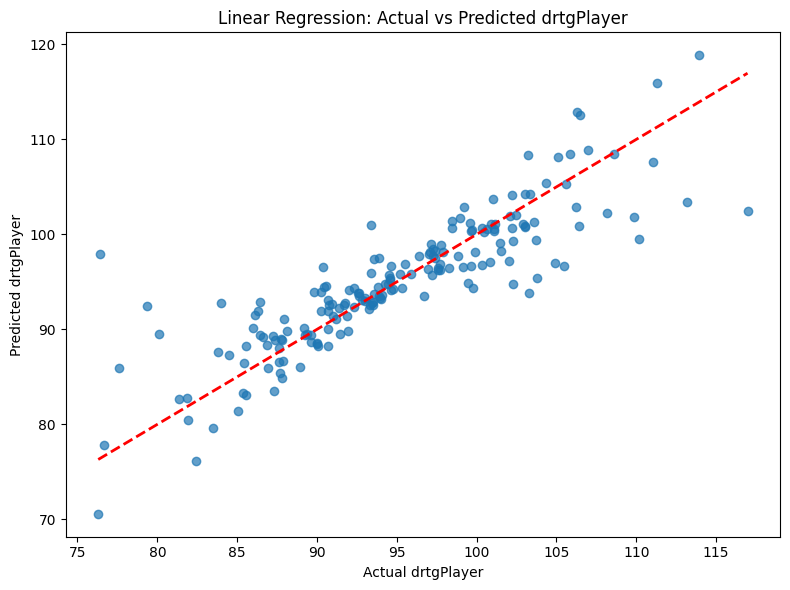

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linreg, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual drtgPlayer")
plt.ylabel("Predicted drtgPlayer")
plt.title("Linear Regression: Actual vs Predicted drtgPlayer")
plt.tight_layout()
plt.show()

In [29]:
# For Linear Regression
linreg_coefs = pd.Series(linreg.coef_, index=X_train_sfs.columns)
linreg_coefs = linreg_coefs.reindex(linreg_coefs.abs().sort_values(ascending=False).index)
print("Linear Regression Feature Importance (Descending):")
print(linreg_coefs)

Linear Regression Feature Importance (Descending):
dws          -70.383181
ws            57.348389
ows          -56.626294
stlPg        -12.247482
mpg            0.495552
stl            0.387397
height        -0.149548
ortgPlayer    -0.064793
dtype: float64


In [21]:
from sklearn.feature_selection import SequentialFeatureSelector

# Forward selection with Linear Regression
sfs = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select="auto",  # or set a number, e.g., 5
    direction="forward",
    scoring="r2",
    cv=5,
    n_jobs=-1
)
sfs.fit(X, y)

selected_features = [feature for feature, selected in zip(features, sfs.get_support()) if selected]
print("Selected features by forward selection:", selected_features)

Selected features by forward selection: ['height', 'mpg', 'ortgPlayer', 'ws', 'ows', 'dws', 'stl', 'stlPg']


In [23]:
X_train_sfs = X_train[selected_features]
X_test_sfs = X_test[selected_features]



linreg = LinearRegression()
linreg.fit(X_train_sfs, y_train)
y_pred_linreg = linreg.predict(X_test_sfs)

rmse_linreg = np.sqrt(mean_squared_error(y_test, y_pred_linreg))
r2_linreg = r2_score(y_test, y_pred_linreg)

print(f"Linear Regression RMSE: {rmse_linreg:.2f}")
print(f"Linear Regression R^2 Score: {r2_linreg:.2f}")


Linear Regression RMSE: 4.00
Linear Regression R^2 Score: 0.73


## Ridge Regression

In [30]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge R^2:", r2_score(y_test, y_pred_ridge))
# For Ridge Regression
ridge_coefs = pd.Series(ridge.coef_, index=X_train.columns)
ridge_coefs = ridge_coefs.reindex(ridge_coefs.abs().sort_values(ascending=False).index)
print("Ridge Regression Feature Importance (Descending):")
print(ridge_coefs)

Ridge RMSE: 4.373194946130755
Ridge R^2: 0.6791313124344909
Ridge Regression Feature Importance (Descending):
dws          -12.833436
stlPg        -12.150517
blkPg         -4.272869
PPP            1.924305
mpg            0.516004
ws             0.486430
stl            0.383564
Poss          -0.226651
height        -0.152662
blk            0.149581
drapm         -0.127889
ows            0.100374
rapm          -0.080315
gp            -0.078825
orapm         -0.065115
PPS           -0.062685
ortgPlayer    -0.039444
dtype: float64


## Lasso Regression

In [31]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("Lasso R^2:", r2_score(y_test, y_pred_lasso))

# Feature importance (coefficients)
lasso_coefs = pd.Series(lasso.coef_, index=X_train.columns)
lasso_coefs = lasso_coefs.reindex(lasso_coefs.abs().sort_values(ascending=False).index)
print("Lasso Regression Feature Importance (Descending):")
print(lasso_coefs)

Lasso RMSE: 4.494358107873249
Lasso R^2: 0.6611051177979415
Lasso Regression Feature Importance (Descending):
dws          -11.237346
stlPg         -9.081812
ows            0.552654
mpg            0.438318
drapm         -0.275061
stl            0.274493
height        -0.163641
rapm          -0.094135
ortgPlayer    -0.044583
Poss           0.030612
blk           -0.002926
gp             0.002350
PPP            0.000000
orapm         -0.000000
blkPg         -0.000000
ws             0.000000
PPS            0.000000
dtype: float64


## Gradient Boost 

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("GBR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("GBR R^2:", r2_score(y_test, y_pred_gbr))

# Feature importance
importances = gbr.feature_importances_
sorted_indices = importances.argsort()[::-1]
for idx in sorted_indices:
    print(f"{features[idx]}: {importances[idx]:.4f}")

GBR RMSE: 3.0051729398703797
GBR R^2: 0.8484804743774456
dws: 0.6261
mpg: 0.1882
gp: 0.0849
stlPg: 0.0324
drapm: 0.0238
rapm: 0.0093
PPS: 0.0089
height: 0.0060
blkPg: 0.0048
ortgPlayer: 0.0043
PPP: 0.0034
ws: 0.0033
orapm: 0.0023
stl: 0.0010
ows: 0.0008
Poss: 0.0003
blk: 0.0002


## Support Vector Regression

In [38]:
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print("SVR RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("SVR R^2:", r2_score(y_test, y_pred_svr))
print("\n")

# Feature importance (coefficients)
svr_coefs = pd.Series(svr.coef_[0], index=X_train.columns)
svr_coefs = svr_coefs.reindex(svr_coefs.abs().sort_values(ascending=False).index)
print("SVR Regression Feature Importance (Descending):")
print(svr_coefs)


SVR RMSE: 4.475391644373185
SVR R^2: 0.6639593963178305


SVR Regression Feature Importance (Descending):
dws          -8.573890
stlPg        -8.421815
blkPg        -3.696981
ows           3.690341
ws           -3.061257
PPP           0.980709
mpg           0.432954
stl           0.274019
blk           0.115928
PPS          -0.071352
height       -0.068601
Poss         -0.052702
rapm         -0.046469
ortgPlayer   -0.042101
drapm        -0.031950
orapm        -0.024664
gp           -0.021805
dtype: float64
